In [1]:
import pandas as pd

# Load the dataset
file_path = "mediaeval-2015-trainingset.txt"

# Read the dataset with tab delimiter
data = pd.read_csv(file_path, sep="\t")

# Display the first few rows of the dataset
data.head()


,tweetId,tweetText,userId,imageId(s),username,timestamp,label
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake


In [2]:
# Check for missing values
missing_values = data.isnull().sum()

# Check for duplicate rows
duplicate_rows = data.duplicated().sum()

missing_values, duplicate_rows


(tweetId       0
 tweetText     0
 userId        0
 imageId(s)    0
 username      0
 timestamp     0
 label         0
 dtype: int64,
 1)

In [3]:
# Remove duplicate rows
data_cleaned = data.drop_duplicates()

# Confirm the duplicate removal
data_cleaned.shape[0]


14276

In [4]:
# Analyze the label distribution
label_distribution = data_cleaned['label'].value_counts()

# Convert to percentage for better understanding
label_percentage = (label_distribution / len(data_cleaned)) * 100

label_distribution, label_percentage


(label
 fake     6742
 real     4920
 humor    2614
 Name: count, dtype: int64,
 label
 fake     47.226114
 real     34.463435
 humor    18.310451
 Name: count, dtype: float64)

C:\Users\87186\AppData\Local\Temp\ipykernel_19120\2763444322.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['tweet_length'] = data_cleaned['tweetText'].str.len()


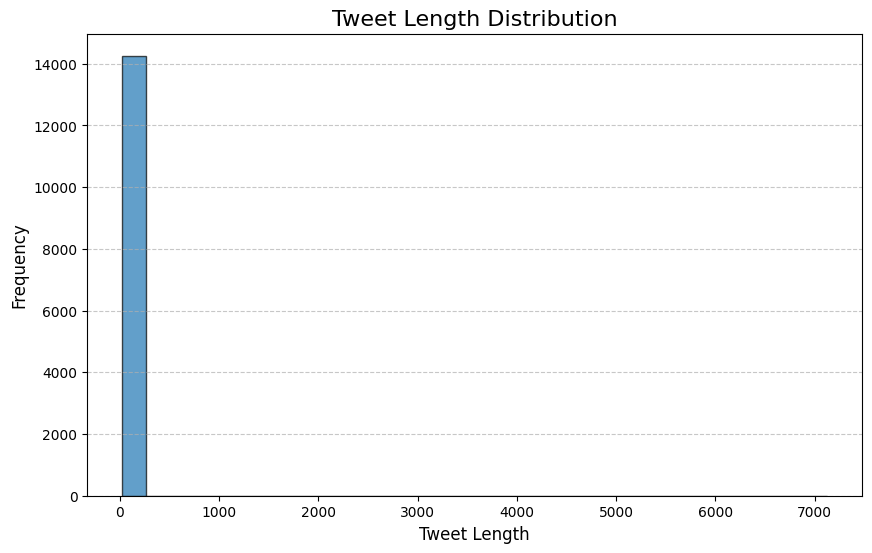

In [5]:
import matplotlib.pyplot as plt

# Calculate the length of each tweet
data_cleaned['tweet_length'] = data_cleaned['tweetText'].str.len()

# Plot the distribution of tweet lengths
plt.figure(figsize=(10, 6))
plt.hist(data_cleaned['tweet_length'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Tweet Length Distribution', fontsize=16)
plt.xlabel('Tweet Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


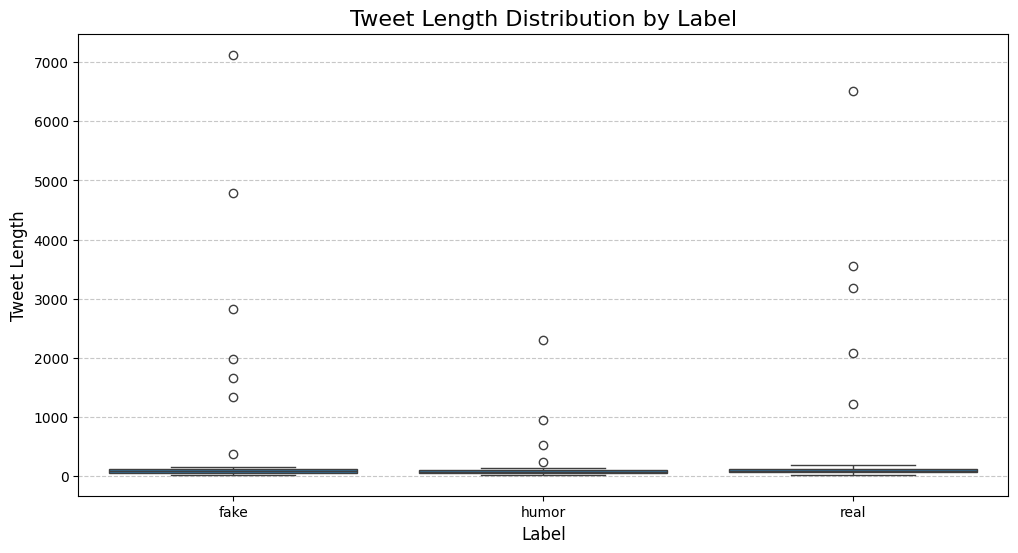

,label,mean,median
0,fake,92.836547,91.0
1,humor,79.626626,75.0
2,real,96.345325,94.0


In [6]:
# Analyze tweet length distribution by label
import seaborn as sns

# Plot the tweet length distribution for each label
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_cleaned, x='label', y='tweet_length')
plt.title('Tweet Length Distribution by Label', fontsize=16)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Tweet Length', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Calculate mean and median tweet lengths for each label
length_stats = data_cleaned.groupby('label')['tweet_length'].agg(['mean', 'median']).reset_index()

length_stats


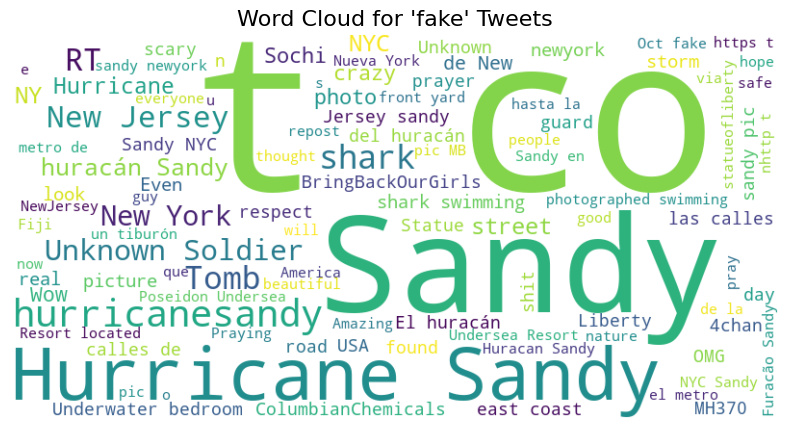

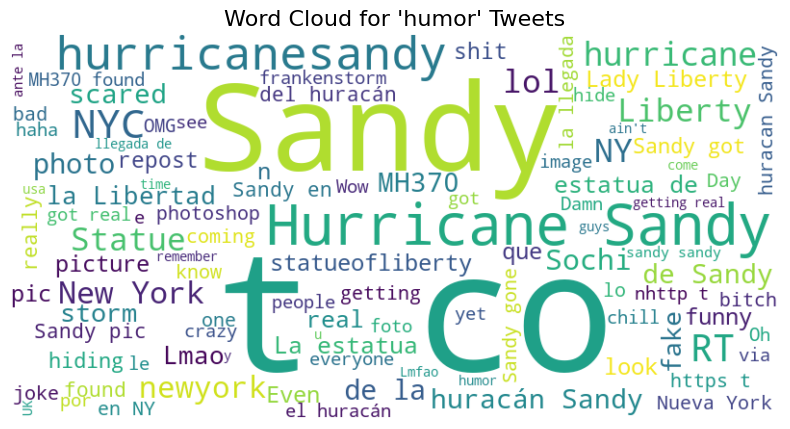

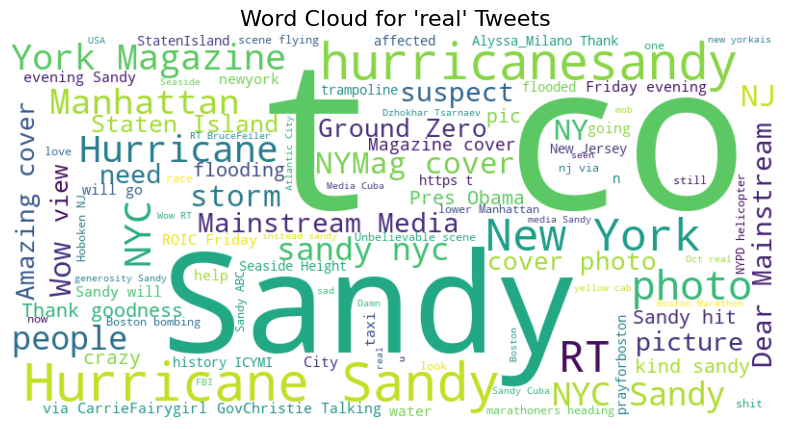

In [7]:
from wordcloud import WordCloud
from collections import Counter

# Function to generate a word cloud for a specific label
def generate_wordcloud(label, data, column='tweetText'):
    text = " ".join(data[data['label'] == label][column])
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for '{label}' Tweets", fontsize=16)
    plt.show()

# Generate word clouds for each label
for label in data_cleaned['label'].unique():
    generate_wordcloud(label, data_cleaned)


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# 定义文件路径
train_file_path = "mediaeval-2015-trainingset.txt"
test_file_path = "mediaeval-2015-testset.txt"

# 加载训练集和测试集
train_data = pd.read_csv(train_file_path, sep="\t")
test_data = pd.read_csv(test_file_path, sep="\t")


# Function to clean the tweet text
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

# 对训练集和测试集清洗推文
train_data['cleaned_text'] = train_data['tweetText'].apply(clean_text)
test_data['cleaned_text'] = test_data['tweetText'].apply(clean_text)

In [9]:
# 安装 transformers 库（如果未安装）
# !pip install transformers

from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm

# 指定本地路径
local_path = "F:\python\SVM_for_FakeNewsDetection-master\models"

# 加载预训练的 BERT 模型和分词器
tokenizer = BertTokenizer.from_pretrained(local_path)
model = BertModel.from_pretrained(local_path)

# 确保模型运行在 GPU 上（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 定义函数，将推文文本转化为 BERT 嵌入
def get_bert_embeddings(texts, tokenizer, model, max_len=128):
    embeddings = []
    for text in tqdm(texts, desc="Encoding texts"):
        # 分词并转化为 BERT 输入格式
        inputs = tokenizer(
            text, 
            max_length=max_len, 
            padding='max_length', 
            truncation=True, 
            return_tensors="pt"
        )
        inputs = {key: val.to(device) for key, val in inputs.items()}
        
        # 提取 BERT 的最后一层隐藏状态
        with torch.no_grad():
            outputs = model(**inputs)
            # 平均池化，获取句子级嵌入
            sentence_embedding = outputs.last_hidden_state.mean(dim=1)
            embeddings.append(sentence_embedding.cpu())
    
    return torch.cat(embeddings, dim=0)

# 提取训练集和测试集的 BERT 嵌入
train_texts = train_data['cleaned_text'].tolist()
test_texts = test_data['cleaned_text'].tolist()

print("Extracting embeddings for training set...")
train_embeddings = get_bert_embeddings(train_texts, tokenizer, model)
print("Extracting embeddings for test set...")
test_embeddings = get_bert_embeddings(test_texts, tokenizer, model)


D:\Anaconda\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\Anaconda\envs\pytorch\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Extracting embeddings for training set...


Encoding texts: 100%|████████████████████████████████████████████████████████████| 14277/14277 [04:07<00:00, 57.70it/s]


Extracting embeddings for test set...


Encoding texts: 100%|██████████████████████████████████████████████████████████████| 3755/3755 [01:07<00:00, 55.70it/s]


NameError: name 'np' is not defined

In [11]:
# 将嵌入保存为 NumPy 数组
import numpy as np
# 保存嵌入（可选）
np.save("train_embeddings.npy", train_embeddings.numpy())
np.save("test_embeddings.npy", test_embeddings.numpy())

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np

# 加载嵌入和标签
# 如果嵌入已经保存到文件，可直接加载
train_embeddings = np.load("train_embeddings.npy")
test_embeddings = np.load("test_embeddings.npy")

# 编码标签
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_data['label'])
test_labels_encoded = label_encoder.transform(test_data['label'])

# 训练逻辑回归模型
print("Training Logistic Regression model...")
from sklearn.utils.class_weight import compute_class_weight

# 计算权重
# 将 classes 转换为 NumPy 数组
classes = np.array(['fake', 'real', 'humor'])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_data['label'])
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# 使用带权重的逻辑回归
clf = LogisticRegression(max_iter=1000, random_state=42, class_weight=class_weights_dict)
clf.fit(train_embeddings, train_labels_encoded)

# 预测测试集
print("Predicting on test set...")
test_preds = clf.predict(test_embeddings)

# 生成分类报告
print("Classification Report:")
print(classification_report(test_labels_encoded, test_preds, target_names=label_encoder.classes_))


Training Logistic Regression model...
Predicting on test set...
Classification Report:
              precision    recall  f1-score   support

        fake       0.80      0.80      0.80      2546
       humor       0.00      0.00      0.00         0
        real       0.63      0.57      0.60      1209

    accuracy                           0.72      3755
   macro avg       0.48      0.45      0.46      3755
weighted avg       0.74      0.72      0.73      3755



D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
